In [1]:
#import librosa
import os
from os.path import isdir, join
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

D:\Users\Testing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\Testing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\Testing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\Testing\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
data_path_1 = 'spk1'
data_path_2 = 'spk2'


In [3]:
def load_speeches(path):
    waves = [f for f in os.listdir(path) if f.endswith('.wav')]
    labels = []
    samples_rate = []
    all_waves = []
    for wav in waves:
        sample_rate, samples = wavfile.read(join(path,wav))
        samples_rate.append(sample_rate)
        labels.append(wav[len(wav)-5])
        all_waves.append(samples)
    return all_waves ,samples_rate,labels


In [4]:
def get_spectrograms(waves):
    sample_rate = 8000
    spectros = []
    freqs = []
    tims = []
    for wav in waves:
        frequencies, times, spectrogram = signal.spectrogram(wav, sample_rate)
        freqs.append(frequencies)
        tims.append(times)
        spectros.append(spectrogram)
    return freqs,tims,spectros


In [5]:
all_waves_1,samples_rate_1,labels_1 = load_speeches(data_path_1)

all_waves_2,samples_rate_2,labels_2 = load_speeches(data_path_2)


In [6]:
max_sequence_len_1 = max([len(x) for x in all_waves_1])
max_sequence_len_2 = max([len(x) for x in all_waves_2])
max_sequence_len_1 ,max_sequence_len_2 


(91601, 107760)

In [7]:
all_waves_1 = np.array(pad_sequences(all_waves_1, maxlen=max_sequence_len_2, padding='post'))
all_waves_2 = np.array(pad_sequences(all_waves_2, maxlen=max_sequence_len_2, padding='post'))


In [8]:
all_waves =  np.vstack((all_waves_1,all_waves_2))


In [9]:
freqs,tims,spectros = get_spectrograms(all_waves)


In [10]:
spectros[1].shape


(129, 480)

In [11]:
spectros = np.array(spectros)


In [12]:
spectros.shape

(1170, 129, 480)

In [13]:
spectros = spectros.reshape(1170,129,480,1)

In [14]:
labels_1 = np.array(labels_1)
labels_2 = np.array(labels_2)


In [15]:
labels_1 = [1 for i in labels_1]

In [16]:
labels_2 = [0 for i in labels_2]

In [17]:
labels_1 = np.array(labels_1).reshape(640,1)

In [18]:
labels_2 = np.array(labels_2).reshape(-1,1)

In [19]:
labels = np.vstack((labels_1,labels_2))


In [20]:
labels.shape

(1170, 1)

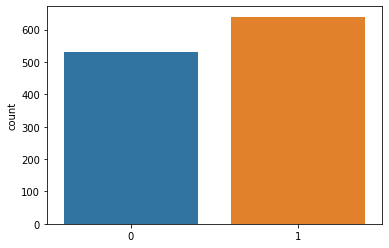

In [21]:
sns.countplot(labels.reshape(-1))

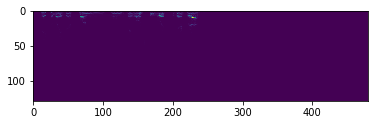

In [33]:
plt.imshow(spectros[800].reshape(129, 480))

In [34]:
import keras
#labels = keras.utils.to_categorical(labels, 2)

Using TensorFlow backend.


In [35]:
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(spectros, labels, test_size=0.2, random_state=42)

In [36]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
import tensorflow as tf

In [37]:
X.shape

(936, 129, 480, 1)

In [46]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(8, (5,5), activation='relu',padding='same', input_shape=(X.shape[1], X.shape[2],1)),
  tf.keras.layers.Conv2D(8,(5,5), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout((0.25)),
  tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same'),
  tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same'),
  tf.keras.layers.Dropout((0.25)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout((0.5)),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout((0.5)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer = tf.keras.optimizers.Adam( epsilon=1e-08), loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 129, 480, 8)       208       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 129, 480, 8)       1608      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 240, 8)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 240, 8)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 240, 16)       1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 240, 16)       2320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 240, 16)      

In [49]:
model.fit(X,Y,batch_size=64,epochs=10,validation_data=(X_test,Y_test))

Train on 936 samples, validate on 234 samples
Epoch 1/10
936/936 [==============================] - 83s 89ms/sample - loss: 0.5346 - accuracy: 0.7468 - val_loss: 0.5539 - val_accuracy: 0.6752
Epoch 2/10
936/936 [==============================] - 83s 88ms/sample - loss: 0.4138 - accuracy: 0.8024 - val_loss: 0.2883 - val_accuracy: 0.8761
Epoch 3/10
936/936 [==============================] - 83s 89ms/sample - loss: 0.3540 - accuracy: 0.8387 - val_loss: 0.1834 - val_accuracy: 0.9274
Epoch 4/10
936/936 [==============================] - 81s 87ms/sample - loss: 0.3281 - accuracy: 0.8686 - val_loss: 0.1316 - val_accuracy: 0.9915
Epoch 5/10
936/936 [==============================] - 84s 90ms/sample - loss: 0.2958 - accuracy: 0.8793 - val_loss: 0.1399 - val_accuracy: 0.9957
Epoch 6/10
936/936 [==============================] - 85s 91ms/sample - loss: 0.2531 - accuracy: 0.9081 - val_loss: 0.1480 - val_accuracy: 0.9915
Epoch 7/10
936/936 [==============================] - 92s 98ms/sample - loss: 

0.99572647

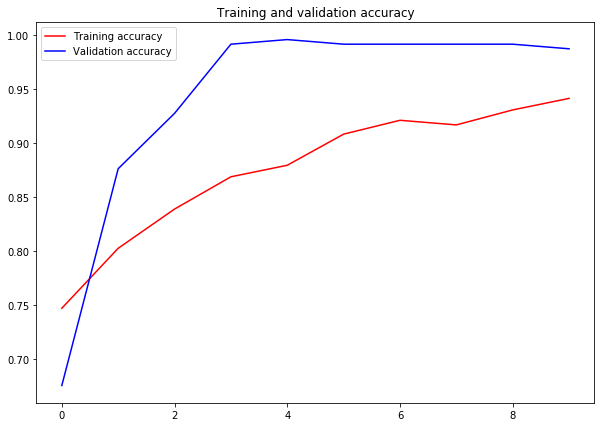

<Figure size 432x288 with 0 Axes>

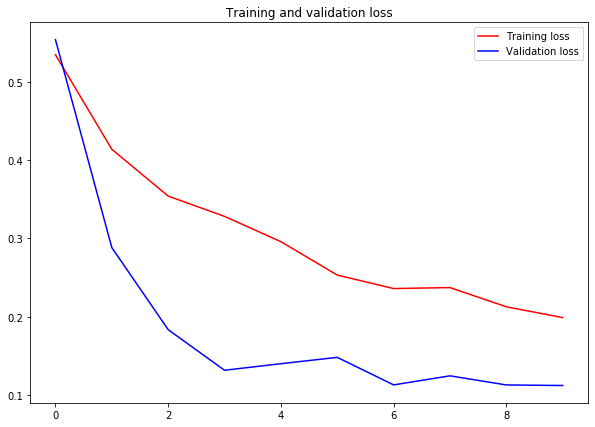

<Figure size 432x288 with 0 Axes>

In [51]:
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
history = model.history
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy','Validation accuracy'])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.legend(['Training loss','Validation loss'])
plt.figure()
max(val_acc) #the best validation accuracy the model have got

In [53]:
from sklearn import metrics

In [54]:
print("Classification report  \n%s\n"
      % ( metrics.classification_report(Y_test, model.predict_classes(X_test))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(Y_test,model.predict_classes(X_test)))

Classification report  
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       1.00      0.98      0.99       129

    accuracy                           0.99       234
   macro avg       0.99      0.99      0.99       234
weighted avg       0.99      0.99      0.99       234


Confusion matrix:
[[105   0]
 [  3 126]]
